<a href="https://colab.research.google.com/github/nikkodote-ai/ML_Stroke_Prediction/blob/main/Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predictive analytics of stroke using Machine-Learning Techniques (Support Vector Machines)

In [37]:
!pip install xgboost
!pip install lightgbm
!pip install catboost


     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [68]:
import pandas as pd

#for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#for machine learning
from sklearn.preprocessing import StandardScaler

#models
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, f1_score

%matplotlib inline


In [41]:
#Data from Kaggle
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [42]:
print(f"Any null values? {df.isna().values.any()}")
print(f"Any duplicate values? {df.duplicated().values.any()}")

Any null values? True
Any duplicate values? False


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


#Preprocessing

In [71]:
columns_to_onehot = ['gender', 'work_type','smoking_status']

def onehot_code(df, columns):
  for column in columns:
    one_hot = pd.get_dummies(df[[column]], prefix= column, prefix_sep="_")
    df = pd.concat([df, one_hot], axis = 1)
    df.drop(column, axis=1, inplace=True)
  return df

def preprocessing(df, target):
  #fill null values with median value; another option is imputation by KNNImputer
  df.fillna(df.median(), inplace=True)
  
  #replace to values to binary
  ##convert ever_married values to boolean so it's machine-interpretable
  df.ever_married.replace({'Yes': 1, 'No':0}, inplace=True)
  df.Residence_type.replace({'Urban': 1, 'Rural':0}, inplace=True)

  #onehot coding
  df = onehot_code(df.copy(), columns_to_onehot)

  #define X and y data
  X = df.drop(target, axis = 1)
  y = df[target]

  #train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, shuffle =True, random_state = 0)

  #scale features
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
  X_test = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

  return X_train, X_test, y_train, y_test




In [72]:
X_train, X_test, y_train, y_test = preprocessing(df, 'stroke')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if sys.path[0] == '':


In [46]:
X_train

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
3378,1.222335,0.344093,-0.314446,-0.241069,-1.377821,-1.015012,2.520083,0.118997,-1.184817,1.184817,0.0,-0.392530,-0.072707,-1.156079,2.303013,-0.387559,-0.648785,-0.464278,1.296341,-0.425628
479,-0.983109,0.477383,3.180194,-0.241069,0.725784,-1.015012,2.065050,-0.101903,-1.184817,1.184817,0.0,-0.392530,-0.072707,0.864993,-0.434214,-0.387559,-0.648785,-0.464278,-0.771402,2.349468
3683,-0.413334,1.632565,-0.314446,4.148186,0.725784,-1.015012,-0.227890,0.352891,-1.184817,1.184817,0.0,-0.392530,-0.072707,-1.156079,2.303013,-0.387559,1.541343,-0.464278,-0.771402,-0.425628
2997,-1.512661,1.232694,-0.314446,4.148186,0.725784,0.985210,2.204804,-0.101903,-1.184817,1.184817,0.0,-0.392530,-0.072707,0.864993,-0.434214,-0.387559,-0.648785,2.153882,-0.771402,-0.425628
286,0.021856,-0.899950,-0.314446,-0.241069,-1.377821,0.985210,-0.258996,0.261932,0.844012,-0.844012,0.0,-0.392530,-0.072707,0.864993,-0.434214,-0.387559,-0.648785,-0.464278,1.296341,-0.425628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,-1.068732,-0.011348,-0.314446,-0.241069,0.725784,-1.015012,-0.394306,0.222950,-1.184817,1.184817,0.0,2.547578,-0.072707,-1.156079,-0.434214,-0.387559,-0.648785,-0.464278,1.296341,-0.425628
466,-1.664199,0.788394,3.180194,-0.241069,0.725784,-1.015012,1.428715,4.069209,0.844012,-0.844012,0.0,-0.392530,-0.072707,0.864993,-0.434214,-0.387559,-0.648785,-0.464278,-0.771402,2.349468
3092,-0.231261,-1.870303,-0.314446,-0.241069,-1.377821,0.985210,-0.188119,-1.440297,0.844012,-0.844012,0.0,-0.392530,-0.072707,-1.156079,-0.434214,2.580255,1.541343,-0.464278,-0.771402,-0.425628
3772,1.209845,1.632565,-0.314446,-0.241069,0.725784,-1.015012,2.007060,0.274926,-1.184817,1.184817,0.0,-0.392530,-0.072707,-1.156079,2.303013,-0.387559,-0.648785,2.153882,-0.771402,-0.425628


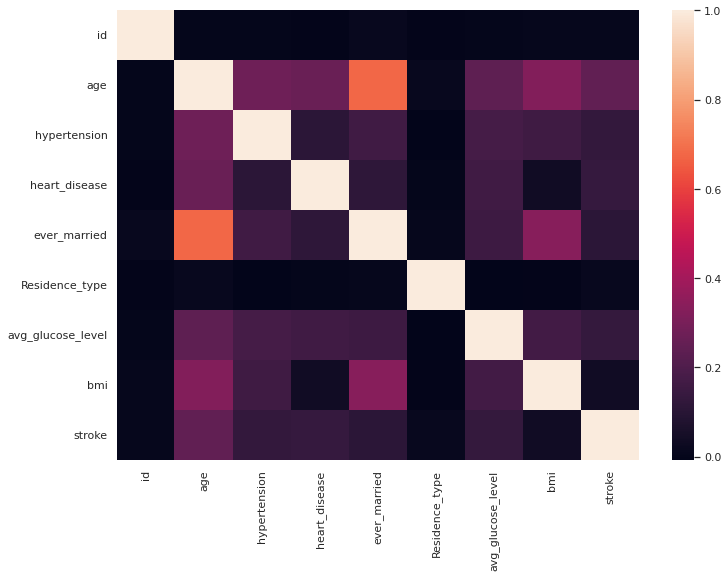

In [47]:
corr = df.corr()

with sns.axes_style('whitegrid'):
  sns.set(rc={'figure.figsize':(11.7,8.27)})
  sns.heatmap(corr)

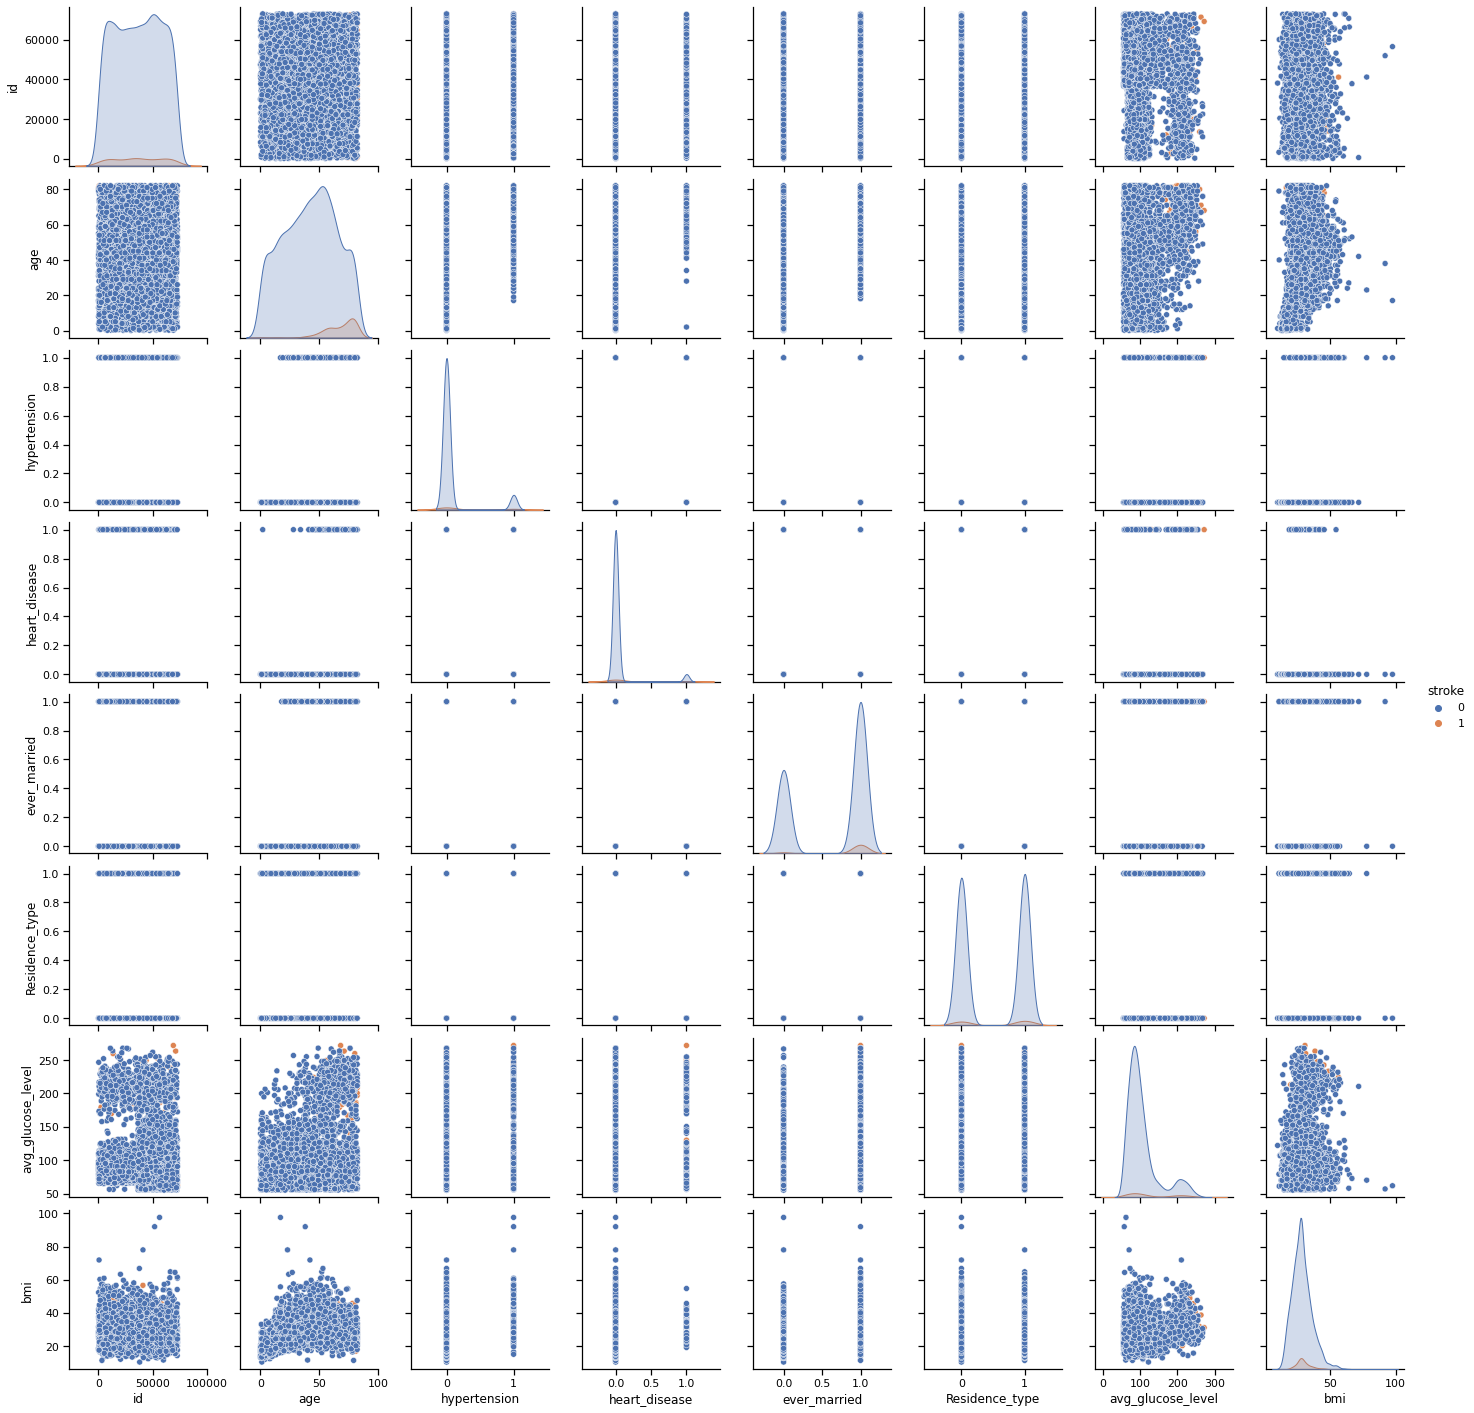

In [48]:
sns.pairplot(df, kind = 'scatter', hue = 'stroke')

In [73]:
#dictionary of ML algorithms
models = {
    "Logistic Regression" : LogisticRegression(), 
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree" : DecisionTreeClassifier(),
    "Support Vector Machine (Light Kernel)": LinearSVC(),
    "Support Vector Machine (RBF Kernel)": SVC(),
    "Neural Network": MLPClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric = "mlogloss"),
    "LightGBM": LGBMClassifier(), 
    "CatBoost":CatBoostClassifier(verbose = 0),
}


In [74]:
for model_name, model in models.items():
  model.fit(X_train, y_train)
  print(f'{model_name} trained')


Logistic Regression trained
K-Nearest Neighbors trained
Decision Tree trained


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Support Vector Machine (Light Kernel) trained
Support Vector Machine (RBF Kernel) trained


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Neural Network trained
Random Forest trained
Gradient Boosting trained
XGBoost trained
LightGBM trained
CatBoost trained


Logistic Regression Accuracy: 0.944   F1-Score: 0.021
Logistic Regression
[[1591    0]
 [  95    1]]
K-Nearest Neighbors Accuracy: 0.943   F1-Score: 0.020
K-Nearest Neighbors
[[1589    2]
 [  95    1]]
Decision Tree Accuracy: 0.902   F1-Score: 0.171
Decision Tree
[[1505   86]
 [  79   17]]
Support Vector Machine (Light Kernel) Accuracy: 0.943   F1-Score: 0.000
Support Vector Machine (Light Kernel)
[[1591    0]
 [  96    0]]
Support Vector Machine (RBF Kernel) Accuracy: 0.943   F1-Score: 0.000
Support Vector Machine (RBF Kernel)
[[1591    0]
 [  96    0]]
Neural Network Accuracy: 0.941   F1-Score: 0.057
Neural Network
[[1584    7]
 [  93    3]]
Random Forest Accuracy: 0.943   F1-Score: 0.000
Random Forest
[[1591    0]
 [  96    0]]
Gradient Boosting Accuracy: 0.941   F1-Score: 0.039
Gradient Boosting
[[1586    5]
 [  94    2]]
XGBoost Accuracy: 0.943   F1-Score: 0.000
XGBoost
[[1590    1]
 [  96    0]]
LightGBM Accuracy: 0.938   F1-Score: 0.055
LightGBM
[[1580   11]
 [  93    3]]
CatBoo

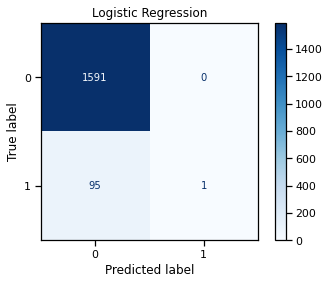

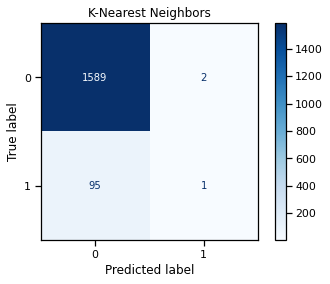

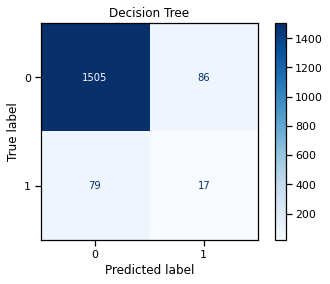

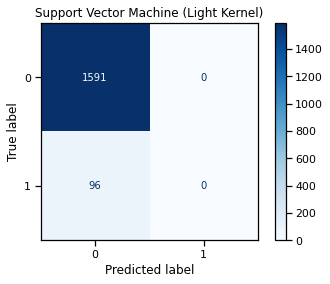

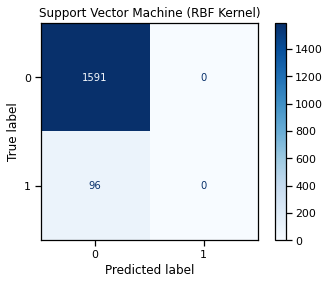

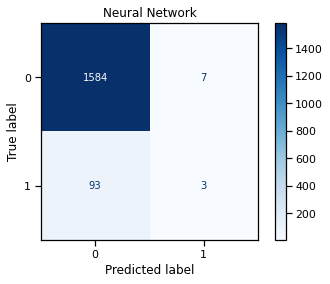

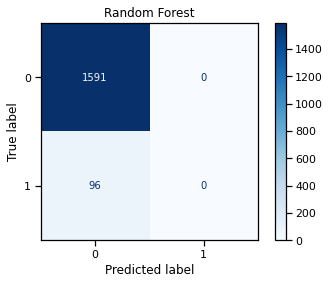

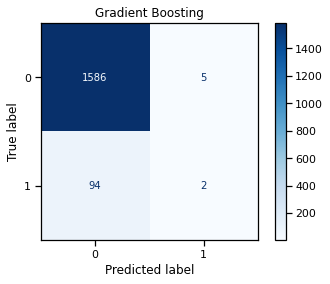

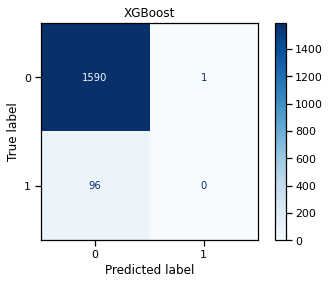

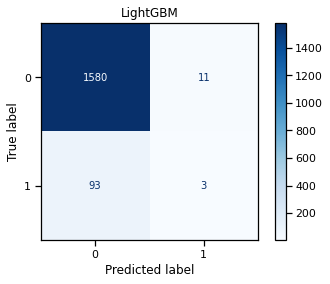

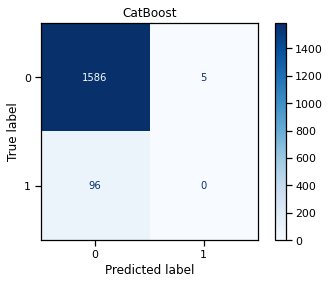

In [70]:
#Performance of the each model

for model_name, model in models.items():
  y_hat = model.predict(X_test)
  print(f'{model_name} Accuracy: {accuracy_score(y_test, y_hat):.3f}   F1-Score: {f1_score(y_test, y_hat):.3f}')
  disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
    )
  disp.ax_.set_title(model_name)

  print(model_name)
  print(disp.confusion_matrix)


##The accuracy is high, but the F1 score is low. Therefore, there is no balance of precision and recall. This is due to significantly higher proportion of False values in stroke compared to True values that during testing, even if the model predicts all the test as False, the accuracy is still high because the proportion of 0 in 'stroke' column in more than 90%. In other words, the model cannot predict a True Stroke, and a Correct prediction of 0 in stroke does not have any clinical value.

</br>

##**To overcome this**, we can artificially increase the number of 1 in stroke column by replicating the data with 1 in stroke. There are some drawbacks. The most obvious is the models train on repeating data. But there might be more benefit to this method than leaving the model as is. This technique of handling class imbalance is called **Oversampling.**


In [ ]:
#combine X_train and y_train to resample random data from the training set
resampled__training_data = pd.concat([X_train, y_train], axis = 1)

#Oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state = 0)
X_resampled, y_resampled = ros.fit

In [78]:
#combine X_train and y_train to resample random data from the training set
resampled_training_data = pd.concat([X_train, y_train], axis = 1).copy()

num_samples = y_train.value_counts()[0] - y_train.value_counts()[1]
new_samples = resampled_training_data.query("stroke == 1").sample(num_samples, replace = True, random_state = 0)

resampled_training_data =  pd.concat([resampled_training_data, new_samples], axis = 0).sample(frac = 1.0, random_state = 0).reset_index(drop=True)

y_train_oversampled = resampled_training_data.stroke
X_train_oversampled = resampled_training_data.drop('stroke', axis = 1)

In [79]:
#TRAIN MODELS WITH RESAMPLED DATA
for model_name, model in models.items():
  model.fit(X_train_oversampled, y_train_oversampled)
  print(f'{model_name} trained on oversampled data')


Logistic Regression trained on oversampled data
K-Nearest Neighbors trained on oversampled data
Decision Tree trained on oversampled data


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Support Vector Machine (Light Kernel) trained on oversampled data
Support Vector Machine (RBF Kernel) trained on oversampled data


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Neural Network trained on oversampled data
Random Forest trained on oversampled data
Gradient Boosting trained on oversampled data
XGBoost trained on oversampled data
LightGBM trained on oversampled data
CatBoost trained on oversampled data


Logistic Regression Accuracy: 0.755   F1-Score: 0.216
Logistic Regression
[[1217  393]
 [  20   57]]
K-Nearest Neighbors Accuracy: 0.852   F1-Score: 0.150
K-Nearest Neighbors
[[1416  194]
 [  55   22]]
Decision Tree Accuracy: 0.916   F1-Score: 0.166
Decision Tree
[[1532   78]
 [  63   14]]
Support Vector Machine (Light Kernel) Accuracy: 0.745   F1-Score: 0.210
Support Vector Machine (Light Kernel)
[[1200  410]
 [  20   57]]
Support Vector Machine (RBF Kernel) Accuracy: 0.791   F1-Score: 0.169
Support Vector Machine (RBF Kernel)
[[1298  312]
 [  41   36]]
Neural Network Accuracy: 0.880   F1-Score: 0.143
Neural Network
[[1467  143]
 [  60   17]]
Random Forest Accuracy: 0.950   F1-Score: 0.023
Random Forest
[[1601    9]
 [  76    1]]
Gradient Boosting Accuracy: 0.807   F1-Score: 0.224
Gradient Boosting
[[1315  295]
 [  30   47]]
XGBoost Accuracy: 0.795   F1-Score: 0.238
XGBoost
[[1287  323]
 [  23   54]]
LightGBM Accuracy: 0.924   F1-Score: 0.228
LightGBM
[[1539   71]
 [  58   19]]
CatBoo

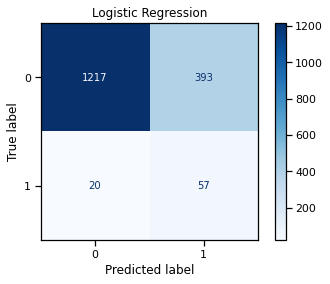

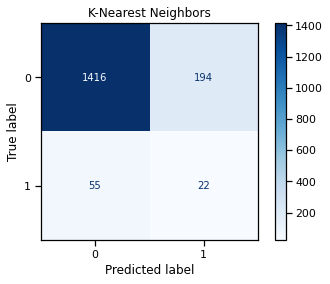

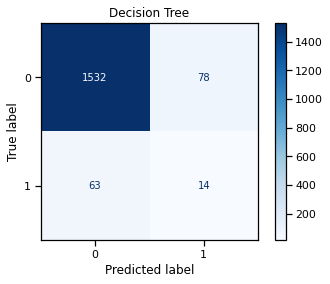

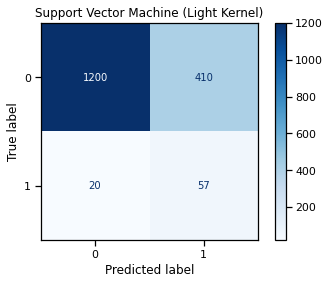

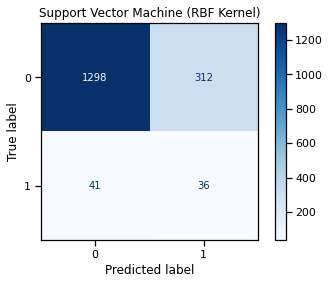

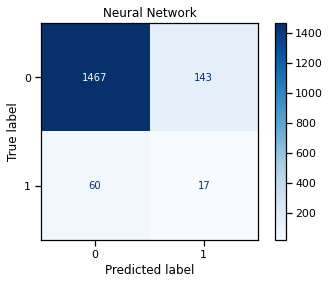

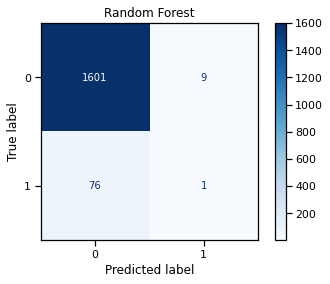

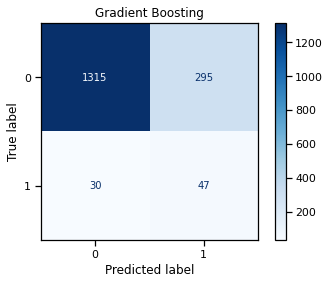

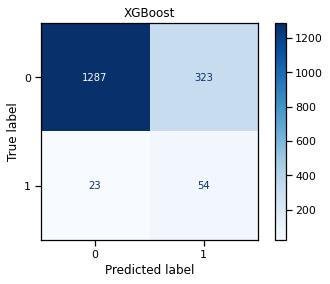

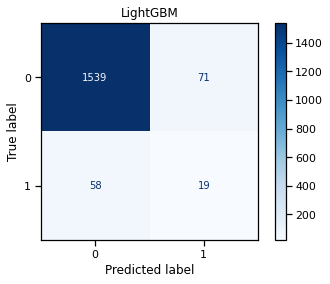

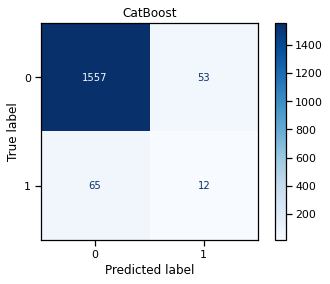

In [80]:
#Performance of the each model

for model_name, model in models.items():
  y_hat = model.predict(X_test)
  print(f'{model_name} Accuracy: {accuracy_score(y_test, y_hat):.3f}   F1-Score: {f1_score(y_test, y_hat):.3f}')
  disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
    )
  disp.ax_.set_title(model_name)

  print(model_name)
  print(disp.confusion_matrix)


After trying to handle the class imbalance using oversampling, the f1 score has improve for most. The best balance between accuracy and f1 score is seen in gradient boosting techniques LightGBM and CatBoost.

There are other ways to handle class imbalance (manipulate class weights, downsample overrepresented clas, use synthetic data)

#CONCLUSION AND RECOMMENDATION: <Br>
##The models predict the not having a stroke accurately and can be utilized by interpreting the likelihood of NOT having a stroke. Although, the other side of the coin in that a stroke patients may be predicted incorrectly which outweighs the benefit of using the model. In the real-world, using battery of tests is usual because each test has a different set of diseases that it can include or exclude in the diagnosis, and needs to be done again if there is an update in the patient condition like a new signs and symptoms. Therefore, I think that kind of approach would be powerful in using ML in healthcare. <br> <br>

##As a medical scientist who works with medical tests, their sensitivity, specificity, interpretation, predictive value; if I frame ML techniques as another lab test that cannot reveal the whole picture on its own, I can see more possibilities in combining intelligent system technology in healthcare.